In [1]:
# 2枚の異なるfocus画像から奥行きを推定するプログラム
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# from tqdm import tqdm  #コマンドラインで実行するとき
from tqdm.notebook import tqdm  # jupyter で実行するとき
from models import RESNETLIKE, MyModel, MyModel_shallow

In [2]:
# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# モデル・損失関数・最適化アルゴリスムの設定
LOAD_WEIGHT = True
model = MyModel(channels=2)

PSIZE = 65
DEPTH_GAP = 100
weight_file = f"weights/weight_{PSIZE}_{DEPTH_GAP}.pth"
#weight_file = f"weights/weight_11000_16000_{PSIZE}_{DEPTH_GAP}.pth"

if LOAD_WEIGHT == True:
    # 学習済みモデルのロード
    model.load_state_dict(torch.load(weight_file))
    model.eval()

model = model.to(device)
model.eval()

MyModel(
  (conv1): Conv2d(2, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (bn64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [4]:
# 画像ペアから奥行きを推定するdataloader
class DepthEstimateData(torch.utils.data.Dataset):
    # FILEはデータが入っていたファイル、imsize = 画像サイズ、psize = パッチサイズ
    def __init__(self, IMGFILES, imsize, psize, channels, transforms):
        self.psize = psize
        self.channels = channels
        self.transforms = transforms
        
        # load file
        for fi in IMGFILES:
            img = Image.open(fi)
            img = img.convert('L')
            img = np.array(img).astype('float32')
            imgs.append(img)

        img = np.stack(imgs,axis=2)
        self.patch = []
        self.loc = []

        self.width = imsize[0]
        self.height = imsize[1]

        # 何ピクセルごとに推定するか? (高速化)
        self.STEP = 5
        
        for y in range(0,self.height-psize,self.STEP):
            for x in range(0,self.width-psize,self.STEP):
                patch = img[y:(y+psize),x:(x+psize)]
                self.patch.append(patch)
                self.loc.append([x,y])
    
    def __len__(self):
        return len(self.patch)

    def __getitem__(self, index):
        return self.transforms(self.patch[index]), self.loc[index]

In [5]:
# 対象となる画像データを読み出す (2 files)

DIR = "data/202410041747/"
psize = 65
width = 1600
height = 1200
DEPTH = 12000
files = [os.path.join(DIR,f"{DEPTH:05d}.bmp"), os.path.join(DIR,f"{DEPTH+50*DEPTH_GAP:05d}.bmp")]
print(files)
imgs = []

trans = transforms.Compose([
    transforms.ToTensor()
])

dataset = DepthEstimateData(IMGFILES=files, imsize=[width,height], psize=psize, channels=2, transforms=trans) 
# データローダーの作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\nakazawa\\Desktop\\LiquidLensProject\\d'

In [ ]:
outputs = []

for data,loc in dataloader:
    data = data.to(device)
    output = model(data).detach().cpu().numpy()
    outputs.append(output)

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

result = np.concatenate(outputs)

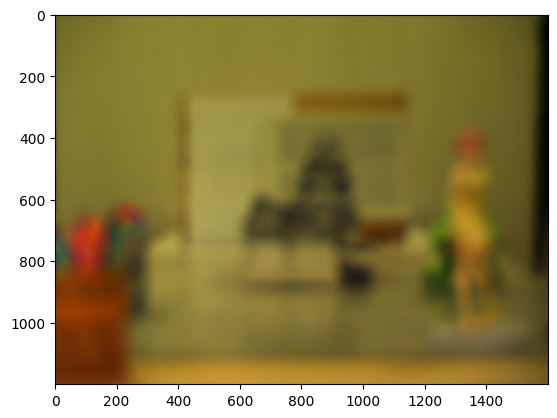

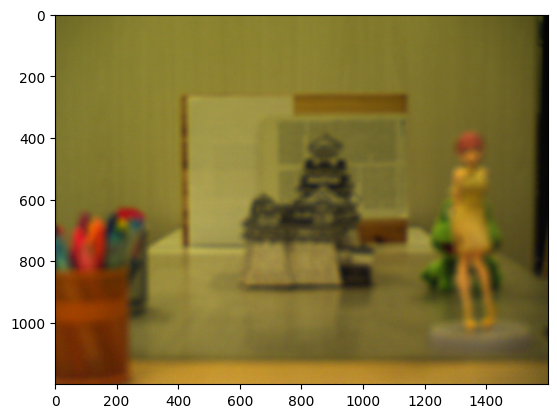

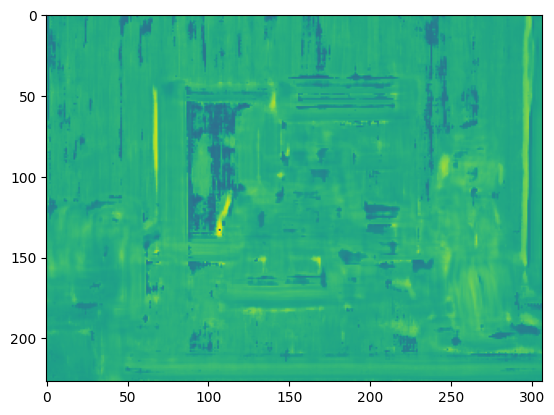

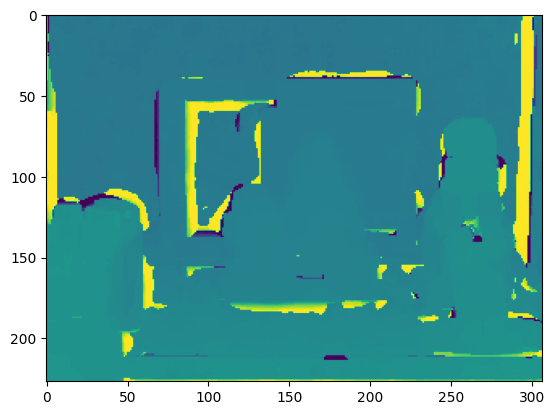

[[-1164.2874 -1785.7899  8263.026  ...  4247.5825  2785.3652  5331.6934]
 [-1232.3291 -2942.3538  8850.036  ...  4585.465   4219.761   5834.772 ]
 [-2302.7893 -2941.8098  8879.356  ...  4761.397   5435.0664  6300.5176]
 ...
 [ 5116.6616  5073.21    5400.8438 ...  5277.6353  5124.3735  5110.6685]
 [ 4961.6846  4769.3257  4789.0615 ...  5814.498   5688.448   5559.4683]
 [ 5734.0215  5593.867   5523.59   ...  5494.4424  5173.751   5094.167 ]]
[[ 1250.   150.  8200. ...  7800.  7800.  8050.]
 [13250.   150.  8000. ...  7800.  8300.  8300.]
 [20000.     0.  8000. ...  7800.  8300.  8300.]
 ...
 [10400. 10400. 10400. ... 10500. 10500. 10500.]
 [10400. 10400. 10400. ... 10950. 10950. 10950.]
 [10400. 10400. 10400. ... 14900. 15100. 16500.]]


In [67]:
import pickle, cv2

# 結果画像
ws = int((width - PSIZE)/5)
hs = int((height - PSIZE)/5)
result2 = result.reshape([hs,ws])

# 正解画像
with open(os.path.join(DIR,"depth.pkl"),'rb') as f:
    gt = pickle.load(f)

plt.imshow(Image.open(files[0]))
plt.show()
plt.imshow(Image.open(files[1]))
plt.show()
plt.imshow(result2.astype("int16"))
plt.show()

# 結果画像をリサイズして表示
gt = gt[0:-1:5,0:-1:5].astype("float")
plt.imshow((gt-DEPTH).astype("int16"))
plt.show()

print(result2)
print(gt-DEPTH)

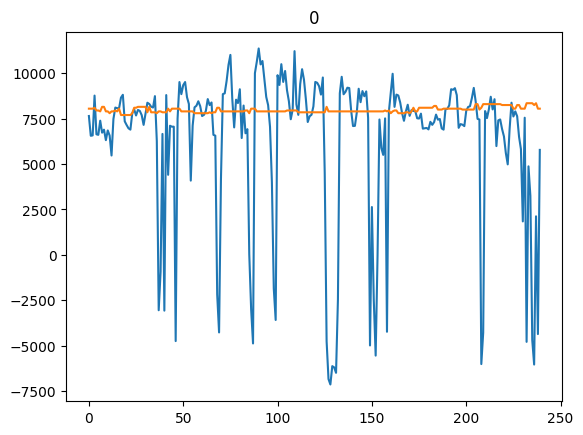

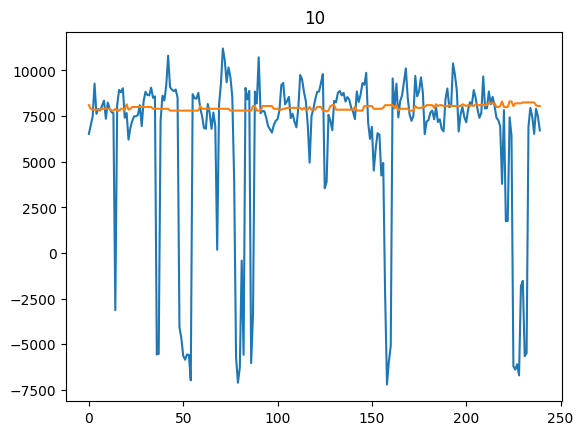

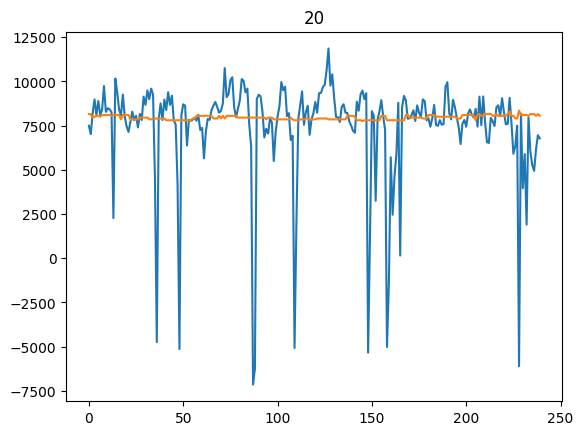

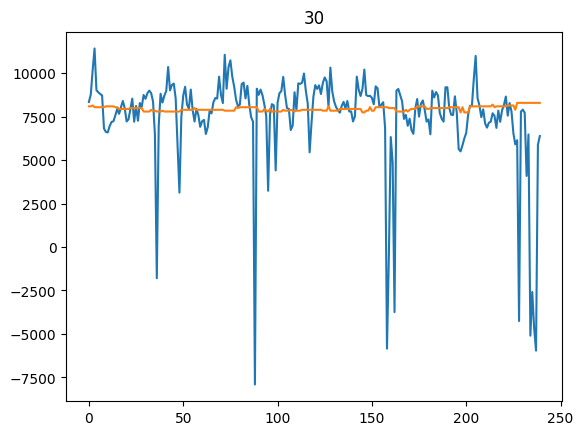

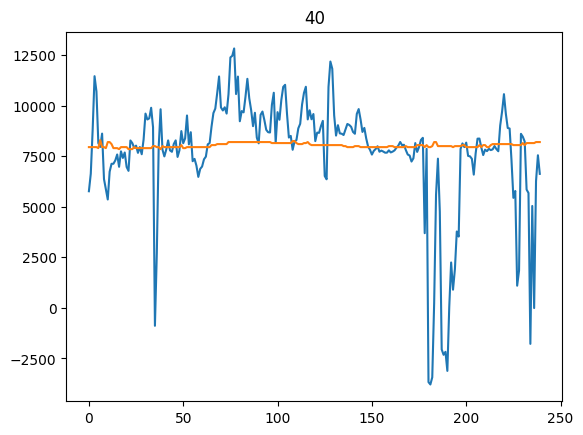

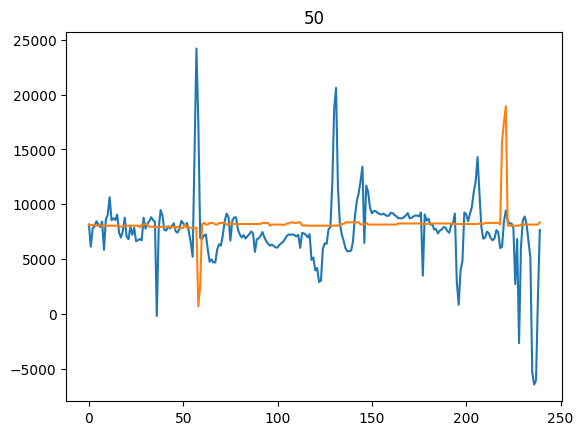

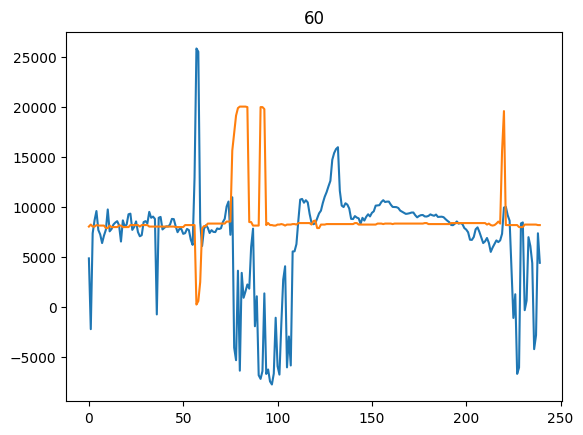

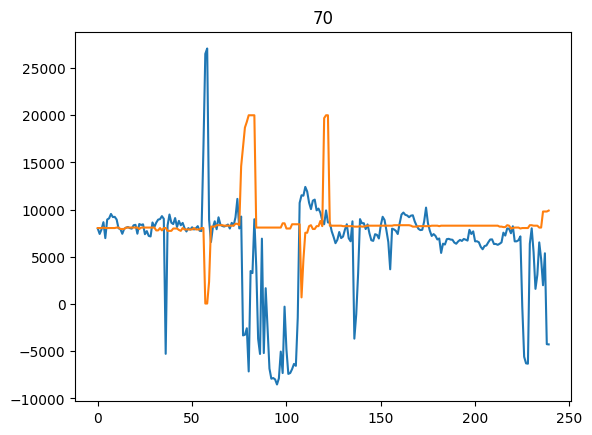

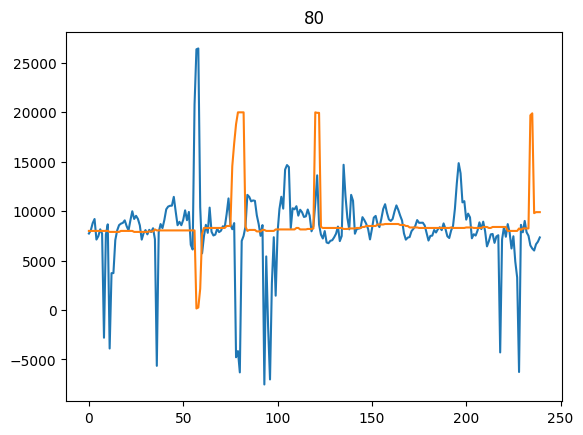

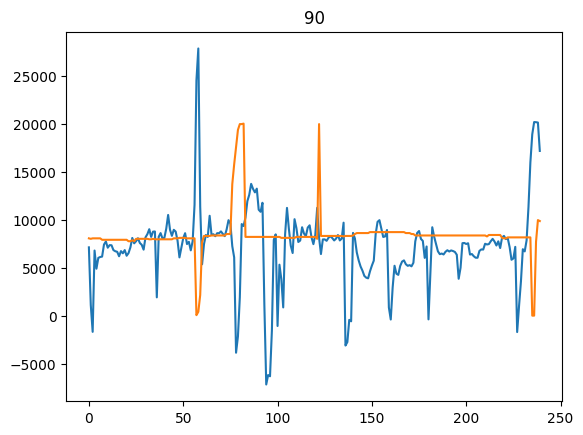

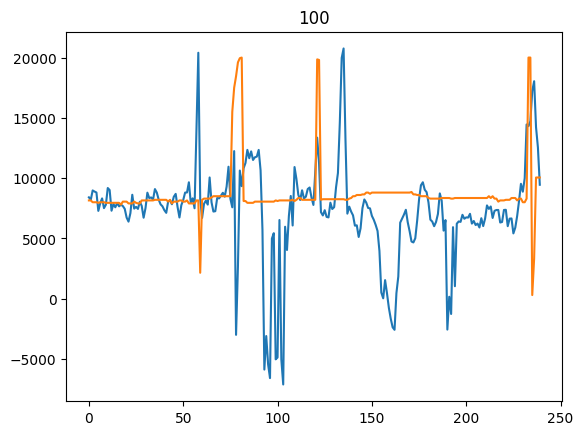

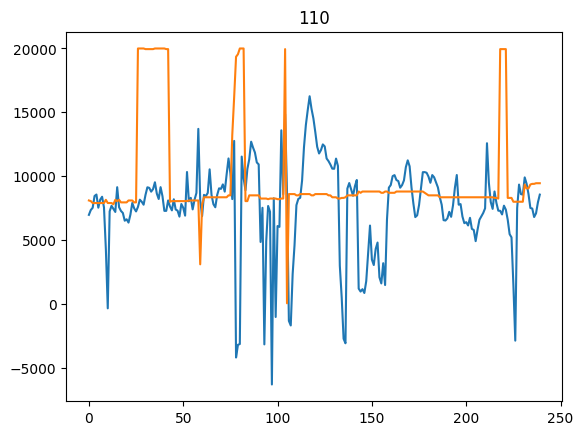

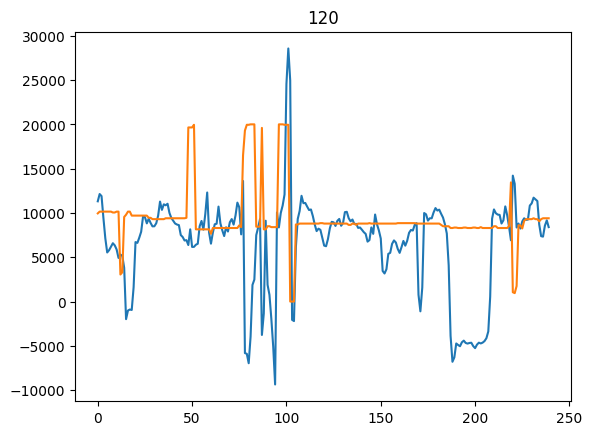

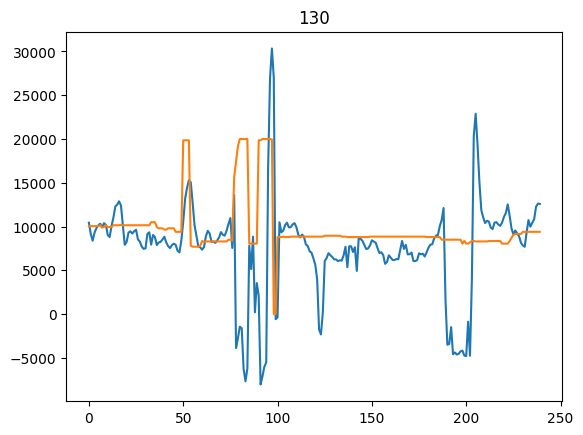

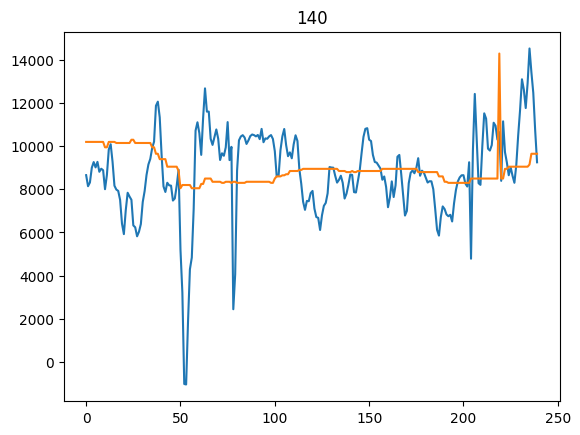

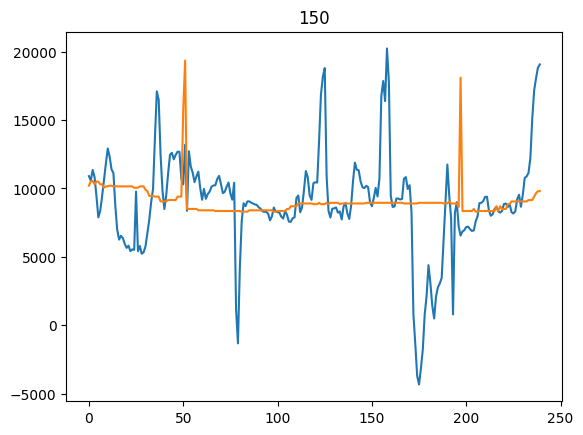

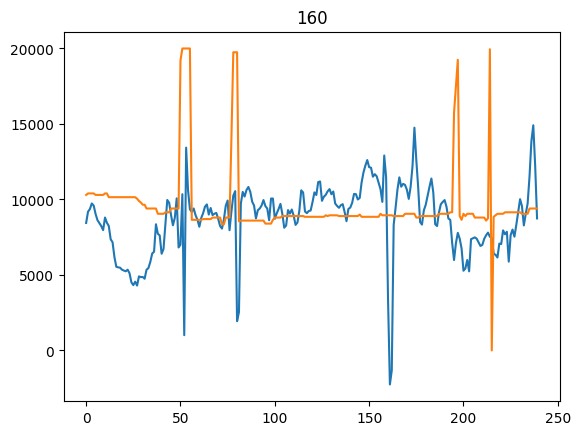

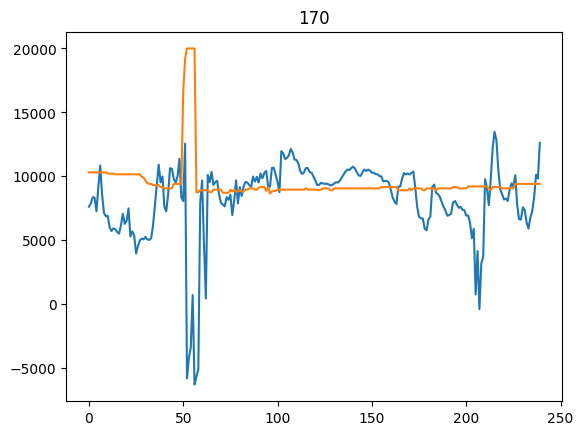

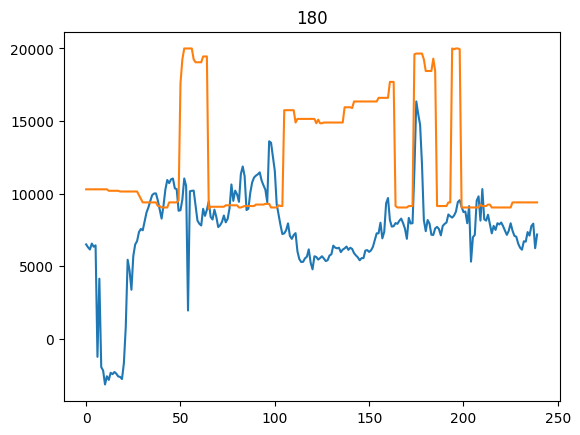

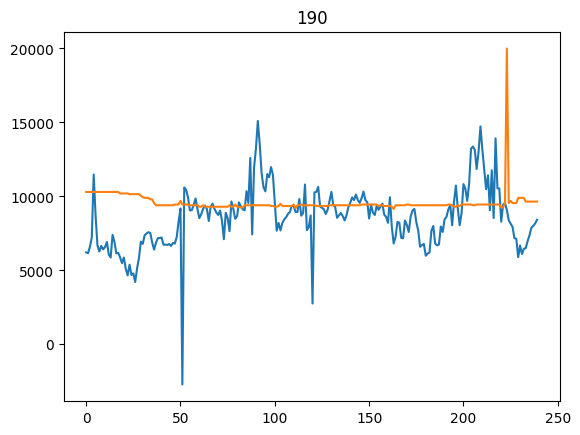

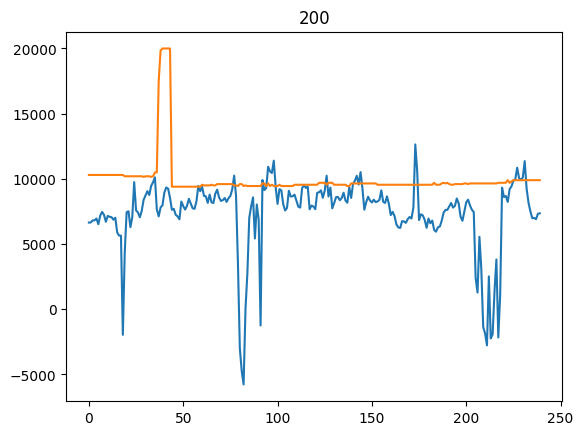

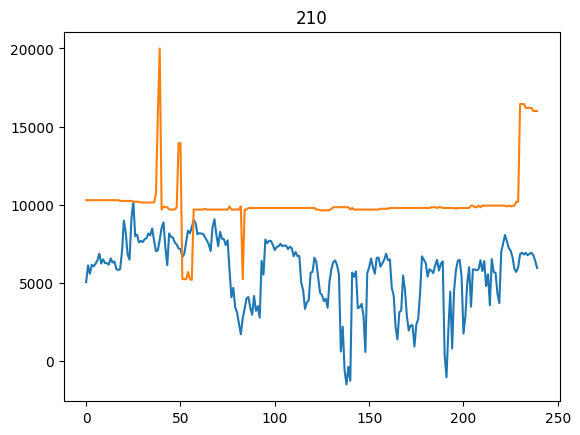

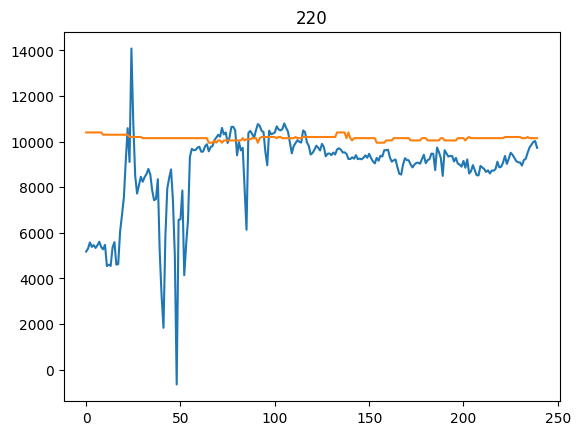

In [68]:
for i in range(0,result2.shape[0],10):
    plt.plot(result2[i][10:250])
    plt.plot((gt-DEPTH)[i][10:250])
    plt.title(i)
    plt.show()

In [11]:
# エラーを計算する
err = np.linalg.norm((gt-DEPTH).flatten()-result2.flatten(),ord=1) / len(result2.flatten())
print("L1 error", err)

# ヒストグラムを表示する
#resultのヒストグラムを表示する
h = plt.hist(result2.flatten(), bins=100)
plt.title("estimated")
plt.show()
#ground truthのヒストグラムを表示する
#plt.hist(gt-DEPTH, bins=h[1])
plt.hist(gt.flatten()-DEPTH,bins=100,range=(h[1][0],h[1][-1]))
plt.title("grand truth")
plt.show()

ValueError: operands could not be broadcast together with shapes (69689,) (64964,) 

In [13]:
with open("result2.txt", "wt") as f:
    for y in range(result2.shape[0]):
        for x in range(result2.shape[1]):
            f.write(f"{x}, {y}, {result2[y,x]*0.1}\n")

with open("gt.txt", "wt") as f:
    for y in range(gt.shape[0]):
        for x in range(gt.shape[1]):
            f.write(f"{x}, {y}, {gt[y,x]*0.1}\n")